# Solar Energy Prediction Starter Code

Dataset Description: https://www.kaggle.com/c/ams-2014-solar-energy-prediction-contest#description

## Before Getting Started
---

### NetCDF (Network Common Data Form)
- UCAR(University Corporation for Atmospheric Research) 에서 주관하는 Unidata 프로젝트에 의해 개발된 포맷으로 기상/해양/대기 분야에서 널리 쓰이는 데이터 포맷
- 2019년 4.7.0 버전부터 S3 읽기 기능 추가
- References
    - 위키피디아: https://en.wikipedia.org/wiki/NetCDF
    - NetCDF Example: http://schubert.atmos.colostate.edu/~cslocum/netcdf_example.html
    
### Data Description
- 훈련셋: 1994년 1월 1일부터 2007년 12월 31일까지의 피쳐 및 정답
- 테스트셋: 2008년 1월 1일부터 2012년 11월 30일까지의 피쳐

#### Ground Truth
- CSV 포맷
- **solar_training_199401_200712.csv**: 1994년 1월 1일부터 운영되고 있는 오클라호마 Mesonet 98곳 사이트에 들어오는 총 태양광 에너지로 5분마다 일사계로 직접 측정 (일출부터 23:55UTC까지 데이터를 모두 합산)
    - Dimension: $5113 \times 99$ (5113일은 1994년 1월 1일부터 2007년 12월 31일까의 총 일수)
    - 1번째 컬럼은 datetime이며, 나머지 컬럼은 98곳 사이트에 대한 태양광 에너지 정답
    
#### Features
- NetCDF4 포맷
- 훈련 파일 및 테스트 파일들은 각각 15개로 구성되어 있으며, 이름 규칙은 아래와 같습니다.
    - Training Dataset: **[Variable]_latlon_subset_19940101_20071231.nc**
    - Test Dataset: **[Variable]_latlon_subset_20080101_20121130.nc**

- 15개 피쳐에 대한 설명은 아래와 같습니다.


|Variable|	설명	| 단위
|---:|---:|---:|
|apcp_sfc|	3시간 동안 표면에 축적된 강수량|	kg m-2
|dlwrf_sfc|	표면에서 하향 장파 복사(long-wave radiative flux) 평균|	W m-2
|dswrf_sfc|	표면에서 하향 단파 복사(short-wave radiative flux) 평균|	W m-2
|pres_msl|	평균 해수면에서의 기압|	Pa
|pwat_eatm|	전체 대기 깊이에 걸쳐 침전 가능한 물|	kg m-2
|spfh_2m|	지상 2m의 특정 습도|	kg kg-1
|tcdc_eatm|	대기의 총 클라우드 커버|	 %
|tcolc_eatm|	전체 대기에 대한 총 컬럼 통합 응축수|	kg m-2
|tmax_2m|	지상 2미터에서 지난 3시간 동안의 최대 온도|	 K
|tmin_2m|	지상 2미터에서 지난 3시간 동안의 최저 온도|	 K
|tmp_2m|	지상 2미터에서의 현재 온도|	 K
|tmp_sfc|	 표면의 현재 온도|	 K
|ulwrf_sfc|	 표면에서의 상향 장파 복사|	 W m-2
|ulwrf_tatm| 대기에서의 상향 장파 복사|	 W m-2
|uswrf_sfc|	 표면에서의 상향 단파 복사|	 W m-2  

- Dimension: $(5113 \times 11 \times 5 \times 9 \times 16)$
    - 5113: timestamp(5,113일)
    - 11: 앙상블 피쳐(11종류의 기상 예보 피쳐)
    - 5: 측정 시간 단위로 12,15,18,21,24시에 총 5번의 예측을 수행
    - 9: GEFS 포인트의 위도
    - 16: GEFS 포인트의  경도
      
#### Stations
- CSV 포맷
- **station_info.csv**
- 98개 Mesonet station의 위도, 경도 및 고도(미터 단위)
    - stid: station id
    - nlat: 위도
    - elon: 경도
    - elev: 고도
- Dimension: $(98 \times 4)$

#### GEFS 정보
- NetCDF4 포맷
- 훈련에 직접적으로 사용하지 않고 검증용으로 사용하는 GEFS 그리드 포인트 정보입니다. 
- **gefs_elevations.nc**


### Install Libraries
`conda_python3` 커널에서 netcdf4 패키지를 설치해 주세요.

In [1]:
#!conda install -c anaconda netcdf4 --yes
#!pip install kaggle opencv-python

<br>

## 1. Prepare Dataset
---

### Download Dataset

본 데이터셋을 다운로드받으려면 Kaggle 계정이 있어야 합니다. Kaggle에 로그인 후, `My Account` - Create New API Token 버튼을 클릭해서 `kaggle.json` 파일을 다운로드하여 노트북 인스턴스로 전송하신 다음, 아래의 코드 셀의 주석을 해제하고 실행해 주세요.

In [2]:
# !mkdir ~/.kaggle
# !cp kaggle.json ~/.kaggle/kaggle.json
# !chmod 600 /home/ec2-user/.kaggle/kaggle.json
# data_dir = "data"
# !rm -rf {data_dir}
# !kaggle competitions download -c ams-2014-solar-energy-prediction-contest -p {data_dir}

In [3]:
# !unzip {data_dir}/ams-2014-solar-energy-prediction-contest.zip -d {data_dir}
# !rm {data_dir}/ams-2014-solar-energy-prediction-contest.zip

In [4]:
# !tar -xzvf {data_dir}/gefs_train.tar.gz
# !tar -xzvf {data_dir}/gefs_test.tar.gz

[Note] 최신 netCDF 패키지는 S3 읽기를 지원하므로, NetCDF 파일들을 S3에 업로드하셔도 됩니다.

In [5]:
import os
import numpy as np
import pandas as pd
from netCDF4 import Dataset, num2date, date2num, date2index

dataset = Dataset('train/apcp_sfc_latlon_subset_19940101_20071231.nc')

In [6]:
print (dataset.file_format)
print ( dataset.dimensions.keys())
print ('time=', dataset.dimensions['time'])
print ('keys=', dataset.variables.keys())
print ('inttime=',dataset.variables['intTime'][0:2])
print ('lat=', dataset.dimensions['lat'])
print ('lat0=', dataset.variables['lat'][0:])
print ('lon=', dataset.dimensions['lon'])
print ('lon=0', dataset.variables['lon'][0:])
print (dataset.variables['Total_precipitation'])
print ('sample=', dataset.variables['Total_precipitation'][0][0][0][0][0])

NETCDF4
odict_keys(['time', 'lat', 'lon', 'ens', 'fhour'])
time= <class 'netCDF4._netCDF4.Dimension'>: name = 'time', size = 5113
keys= odict_keys(['time', 'intTime', 'lat', 'lon', 'ens', 'fhour', 'intValidTime', 'Total_precipitation'])
inttime= [1994010100 1994010200]
lat= <class 'netCDF4._netCDF4.Dimension'>: name = 'lat', size = 9
lat0= [31. 32. 33. 34. 35. 36. 37. 38. 39.]
lon= <class 'netCDF4._netCDF4.Dimension'>: name = 'lon', size = 16
lon=0 [254. 255. 256. 257. 258. 259. 260. 261. 262. 263. 264. 265. 266. 267.
 268. 269.]
<class 'netCDF4._netCDF4.Variable'>
float32 Total_precipitation(time, ens, fhour, lat, lon)
    _FillValue: 9999.0
    units: kg m-2
    long_name: Total_precipitation_Accumulation (Accumulation for  Mixed Intervals) @ surface
    cell_methods: time: sum
    GRIB_param_discipline: Meteorological_products
    GRIB_param_category: Moisture
    GRIB_param_name: Total_precipitation
    GRIB_generating_process_type: Forecast
    GRIB_param_id: [2 0 1 8]
    GRIB_pr

In [7]:
print ('keys=', dataset.variables.keys())
print ('inttime=',dataset.variables['intTime'][0:2])

keys= odict_keys(['time', 'intTime', 'lat', 'lon', 'ens', 'fhour', 'intValidTime', 'Total_precipitation'])
inttime= [1994010100 1994010200]


In [8]:
lon = dataset.variables['lon'][:]
lat = dataset.variables['lat'][:]
print(lat, lon)
print(lat.shape, lon.shape)

[31. 32. 33. 34. 35. 36. 37. 38. 39.] [254. 255. 256. 257. 258. 259. 260. 261. 262. 263. 264. 265. 266. 267.
 268. 269.]
(9,) (16,)


In [9]:
fhour = dataset.variables['fhour'][:]
print(fhour)

[12 15 18 21 24]


In [10]:
time = dataset.variables['time']
print(time.shape)
dtime = num2date(time[:], time.units)
print(dtime)
nptimes = dtime.astype('datetime64[ns]')
print(nptimes)

(5113,)
[cftime.DatetimeGregorian(1994, 1, 1, 0, 0, 0, 0)
 cftime.DatetimeGregorian(1994, 1, 2, 0, 0, 0, 0)
 cftime.DatetimeGregorian(1994, 1, 3, 0, 0, 0, 0) ...
 cftime.DatetimeGregorian(2007, 12, 29, 0, 0, 0, 0)
 cftime.DatetimeGregorian(2007, 12, 30, 0, 0, 0, 0)
 cftime.DatetimeGregorian(2007, 12, 31, 0, 0, 0, 0)]
['1994-01-01T00:00:00.000000000' '1994-01-02T00:00:00.000000000'
 '1994-01-03T00:00:00.000000000' ... '2007-12-29T00:00:00.000000000'
 '2007-12-30T00:00:00.000000000' '2007-12-31T00:00:00.000000000']


5-D Data; 날짜(년-월-일) x # features x 측정시간(12/15/18/21/24시) x 위도 x 경도

In [11]:
features = dataset.variables['Total_precipitation'][:]
print(features.shape)

(5113, 11, 5, 9, 16)


<br>

## 2. Explore Dataset
---

데이터셋을 자유롭게 탐색해 보세요.

### Ground Truth CSV for Training 

1994년 1월 1일부터 운영되고 있는 오클라호마 Mesonet 사이트에 들어오는 총 태양광 에너지로 5분마다 일사계로 직접 측정 (일출부터 23:55UTC까지 데이터를 모두 합산)

In [12]:
train_df = pd.read_csv("data/solar_training_199401_200712.csv")
display(train_df.head())
print(train_df.shape)

,Date,ACME,ADAX,ALTU,APAC,ARNE,BEAV,BESS,BIXB,BLAC,...,VINI,WASH,WATO,WAUR,WEAT,WEST,WILB,WIST,WOOD,WYNO
0,19940101,12384900.0,11930700.0,12116700.0,12301200.0,10706100.0,10116900.0,11487900.0,11182800.0,10848300.0,...,10771800.0,12116400.0,11308800.0,12361800.0,11331600.0,10644300.0,11715600.0,11241000.0,10490100.0,10545300.0
1,19940102,11908500.0,9778500.0,10862700.0,11666400.0,8062500.0,9262800.0,9235200.0,3963300.0,3318300.0,...,4314300.0,10733400.0,9154800.0,12041400.0,9168300.0,4082700.0,9228000.0,5829900.0,7412100.0,3345300.0
2,19940103,12470700.0,9771900.0,12627300.0,12782700.0,11618400.0,10789800.0,11895900.0,4512600.0,5266500.0,...,2976900.0,11775000.0,10700400.0,12687300.0,11324400.0,2746500.0,3686700.0,4488900.0,9712200.0,4442100.0
3,19940104,12725400.0,6466800.0,13065300.0,12817500.0,12134400.0,11816700.0,12186600.0,3212700.0,8270100.0,...,3476400.0,12159600.0,11907000.0,12953100.0,11903700.0,2741400.0,4905000.0,4089300.0,11401500.0,4365000.0
4,19940105,10894800.0,11545200.0,8060400.0,10379400.0,6918600.0,9936300.0,6411300.0,9566100.0,8009400.0,...,6393300.0,11419500.0,7334400.0,10178700.0,7471500.0,8235300.0,11159100.0,10651500.0,10006200.0,8568300.0


(5113, 99)


98개 Mesonet station의 통계치 뽑기 (Station Info와 join하기 위한 목적)

In [13]:
solar_stats = train_df.agg(['max', 'min', 'mean']).drop('Date', axis=1).transpose()
solar_stats.head()

,max,min,mean
ACME,31347900.0,0.0,1.688911e+07
ADAX,31227000.0,0.0,1.625086e+07
ALTU,31411500.0,0.0,1.722924e+07
APAC,31616100.0,3300.0,1.701057e+07
ARNE,32645700.0,477300.0,1.756017e+07


### Station Info
98개 Mesonet station의 위도, 경도 및 고도(미터 단위)

In [14]:
station_df = pd.read_csv("data/station_info.csv")
display(station_df.head())
print(station_df.shape)

,stid,nlat,elon,elev
0,ACME,34.80833,-98.02325,397
1,ADAX,34.79851,-96.66909,295
2,ALTU,34.58722,-99.33808,416
3,APAC,34.91418,-98.29216,440
4,ARNE,36.07204,-99.90308,719


(98, 4)


Ground truth 통계치를 Station Info에 Join합니다.

In [15]:
station_df.set_index('stid', inplace=True)
station_df = station_df.join(solar_stats, how='left')
display(station_df.head())

,nlat,elon,elev,max,min,mean
stid,,,,,,
ACME,34.80833,-98.02325,397,31347900.0,0.0,1.688911e+07
ADAX,34.79851,-96.66909,295,31227000.0,0.0,1.625086e+07
ALTU,34.58722,-99.33808,416,31411500.0,0.0,1.722924e+07
APAC,34.91418,-98.29216,440,31616100.0,3300.0,1.701057e+07
ARNE,36.07204,-99.90308,719,32645700.0,477300.0,1.756017e+07


### Dataset

특정 날짜의 경우 각 앙상블 멤버에 대한 5개의 예측 시간에 대한 합계를 취한 후, 합계된 앙상블의 평균을 취하여 이를 시각화해봅니다.

In [16]:
%matplotlib inline
def visualize_GEFS_grid(time):
    import cv2
    import matplotlib.pyplot as plt
    date_idx = np.where(dataset.variables['intTime'][:] == time)[0]
    hour_idx = np.where(dataset.variables['fhour'][:] <= 24)[0]
    tmp = list(dataset.variables.values())[-1][date_idx,:,hour_idx,:,:]
    grid = tmp.sum(axis=2).mean(axis=1).squeeze()
    grid_resize = cv2.resize(grid, (100, 100))
    plt.imshow(grid_resize)
    plt.colorbar()
    
    return grid

1994년 1월 1일의 집계(aggregated) 피쳐입니다.

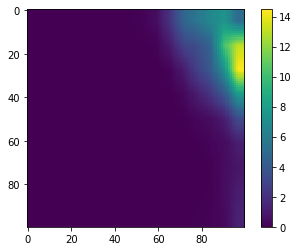

In [17]:
grid = visualize_GEFS_grid(1994010100)

1995년 1월 21일의 집계(aggregated) 피쳐입니다.

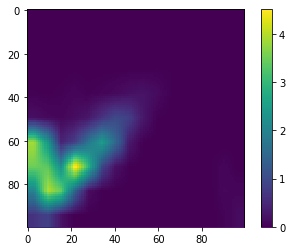

In [18]:
grid = visualize_GEFS_grid(1995012100)

### GEFS

In [19]:
gefs = Dataset('data/gefs_elevations.nc')
gefs

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): lon(16), lat(9)
    variables(dimensions): float32 elevation_control(lat,lon), float32 elevation_perturbation(lat,lon), float32 latitude(lat,lon), float32 longitude(lat,lon)
    groups: 

### Features

In [20]:
dataset = Dataset('train/apcp_sfc_latlon_subset_19940101_20071231.nc')

In [21]:
dataset

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    Conventions: CF-1.0
    title: Subset of data from 2nd-generation multi-decadal ensemble reforecast generated from the NCEP Global Ensemble Forecast System, mimicking version operational at NCEP/EMC circa mid-2012.
    institution: NOAA Earth System Research Laboratory (ESRL)
    source: NCEP GFS v 9.01, T254L42.  Control initial conditions from CFSRR.  Perturbed initial conditions from ETR.  Model error simulated with STTP.
    references: http://www.esrl.noaa.gov/psd/forecasts/reforecast2/index.html
    history: Subset created 2013-01-15 19:18:02 UTC
    comment: Original dataset generated on DOE's supercomputers at Lawrence Berkeley Laboratory through ALCC/ASCR grant.
    dimensions(sizes): time(5113), lat(9), lon(16), ens(11), fhour(5)
    variables(dimensions): float64 time(time), int32 intTime(time), float32 lat(lat), float32 lon(lon), int16 ens(ens), int32 fhour(fhour), int32 intValidTime(t

<br>

## 4. Baseline Modeling
---

scikit-learn의 빌트인 알고리즘 중 Random Forest로 baseline 모델링을 수행해 봅니다.

- Baseline으로 scikit-learn의 다양한 Regressor들을 활용 가능
- SageMaker의 built-in XGBoost를 써도 무방

In [22]:
import os
# 측정치: 11개 앙상블 결과와 5개 시간 데이터의 평균으로 문제 간소화
# 위도/경도 정보는 보존해야 하므로 144차원으로 reshape (9 x 16 = 144)
def get_predictor(path, predictor, postfix):
    
    filepath = os.path.join(path, predictor + postfix)
    X = Dataset(filepath)
    X = dataset.variables['Total_precipitation'][:]
    X = X.reshape(X.shape[0], 55, 9, 16)
    X = np.mean(X, axis=1)
    X = X.reshape(X.shape[0], np.prod(X.shape[1:])) 
    
    return X

# Dimension should be of timestamp x 2160
# 144 x 15개의 predictor 정보를 한꺼번에 concatenate하여 훈련을 수행하는 것이 효율적임
def get_all_predictors(path, predictors, postfix):
    for i, predictor in enumerate(predictors):
        if i == 0:
            X = get_predictor(path, predictor, postfix)
        else:
            X_append = get_predictor(path, predictor, postfix)
            X = np.hstack((X, X_append))

    return X

def import_csv_data():
    df_train = np.loadtxt('data/train.csv', delimiter=',', dtype=float, skiprows=1)

    return df_train

def split_times(df_data):
    times = df_data[:, 0].astype(int)
    data = df_data[:, 1:]

    return times, data

In [23]:
predictors = ['apcp_sfc','dlwrf_sfc','dswrf_sfc','pres_msl','pwat_eatm',\
              'spfh_2m','tcdc_eatm','tcolc_eatm','tmax_2m','tmin_2m',\
              'tmp_2m','tmp_sfc','ulwrf_sfc','ulwrf_tatm','uswrf_sfc']

train_path = 'train'
test_path = 'test'
train_postfix = '_latlon_subset_19940101_20071231.nc'
test_postfix = '_latlon_subset_20080101_20121130.nc'



`apcp_sfc` (3시간 누적 강수량) 에 대한 피쳐(feature)를 확인해 봅니다. 피쳐셋의 차원은 $5113 \times 144$가 되어야 합니다.

In [24]:
x = get_predictor('train', predictors[0], train_postfix)

In [25]:
x

masked_array(
  data=[[0.        , 0.        , 0.        , ..., 0.02927272, 0.06854544,
         0.27690914],
        [0.        , 0.        , 0.        , ..., 0.4425454 , 0.19709091,
         0.156     ],
        [0.        , 0.        , 0.        , ..., 0.4116363 , 0.5930909 ,
         0.47581828],
        ...,
        [0.00090909, 0.00109091, 0.00090909, ..., 0.00236364, 0.00763636,
         0.00072727],
        [0.        , 0.        , 0.        , ..., 0.02418181, 0.02254545,
         0.00854545],
        [0.        , 0.        , 0.        , ..., 0.61163634, 0.48018187,
         0.2814546 ]],
  mask=False,
  fill_value=1e+20,
  dtype=float32)

In [26]:
print(x.shape)

(5113, 144)


15종류의 predictor에 대한 모든 feature를 얻습니다.
- X 변수의 차원: $(5113 \times 2160)$
    - 144 x 15 = 2160; 15종류의 predictor 정보를 한꺼번에 concatenate하기 때문입니다.
- y 변수의 차원: $(5113 \times 98)$
    - 98개의 다중 변수 예측 문제이기 때문입니다.


In [27]:
%%time
train_x_all = get_all_predictors(train_path, predictors, train_postfix)
test_x_all = get_all_predictors(test_path, predictors, test_postfix)

CPU times: user 39.4 s, sys: 1.86 s, total: 41.3 s
Wall time: 41.3 s


In [28]:
ground_truth = np.loadtxt('data/train.csv', delimiter=',', dtype=float, skiprows=1)
timesteps = ground_truth[:, 0].astype(int)
train_y_all = ground_truth[:, 1:]
del ground_truth

In [29]:
train_x_all.shape, test_x_all.shape,train_y_all.shape

((5113, 2160), (5113, 2160), (5113, 98))

훈련 데이터/검증 데이터를 분리합니다.

In [30]:
from sklearn.model_selection import train_test_split
trn_x, vld_x, trn_y, vld_y = train_test_split(train_x_all, train_y_all, test_size=1000)

훈련 시작 (Decision tree 계열은 굳이 scaling할 필요가 없지만, 만약 logistic regression이나 딥러닝 계열로 훈련을 수행하면 scaling이 필요합니다.)

In [31]:
%%time
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(n_estimators=5)
model.fit(trn_x, trn_y)

CPU times: user 1min 3s, sys: 6.71 ms, total: 1min 3s
Wall time: 1min 3s


RandomForestRegressor(n_estimators=5)

<br>

## 5. Prediction
---

훈련된 모델을 사용해 검증셋이나 훈련셋에 대해 예측을 수행합니다.

In [32]:
vld_y_pred = model.predict(vld_x)

In [33]:
vld_y_pred

array([[16292160., 15619740., 15894180., ..., 18296700., 12766560.,
        13782480.],
       [10731780.,  8740740., 11581140., ...,  6314760., 10105980.,
         9104760.],
       [12102720., 10867200., 14062980., ...,  9041940., 13446240.,
        12988680.],
       ...,
       [21584520., 22213500., 19173360., ..., 19532700., 15209820.,
        21627180.],
       [25826220., 24367800., 24537300., ..., 24655860., 25128180.,
        24945780.],
       [ 8201400.,  7596720., 10871160., ...,  6632940., 11584860.,
         7293420.]])

In [34]:
test_y_pred = model.predict(test_x_all)

In [35]:
test_y_pred

array([[14324280., 14011800., 14125980., ..., 13092060., 12791580.,
        12682560.],
       [15415380., 13178400., 14202240., ...,  9059580., 11023860.,
         7527540.],
       [12616020., 10372320., 12653340., ...,  6031800., 10177200.,
         5932980.],
       ...,
       [12544740., 12775620., 13280280., ..., 12890700., 12039660.,
        11966100.],
       [21646560., 19006500., 21477900., ..., 19573140., 23171220.,
        18172620.],
       [14386860., 14365380., 14072940., ..., 13931940., 11235360.,
        13354980.]])